# <center> Analysis of Grade Inflation at the University of Maryland


Group Members: Jihyo Park, Calvin Pham

### <center> Introduction

Grades are a method of evaluation used to measure a student's academic learning. This allows instructors, employers, and colleges to determine how knowledgable a student is. Students worldwide share a common goal of increasing their grades to show that they have mastered the skills and knowledge from school. In recent times, high schools and colleges show signs of grade inflation worldwide. Grade inflation is a phenomonenon that is described as the awarding of higher grades for the same quality of work as time progresses. This phenomenon is critical to the world of education as it impacts students, universities, and employers. Grade inflation causes a variety of problems, for students and employers alike. Academic standards and effort drop, leading to students who are unprepared for the professional world. 

There are multiple reasons why grade inflation may occur, ranging from institution's desire to have high graduation and retention rates, a professor's desire to have positive evaluations, along with other reasons. This is important to discuss because it may give students a false sense of ability, and reduce their motivation to learn. For employers, it may be harder to differentiate students who are qualified versus those who aren't based on inflated grades. Institutions who hold strict grading standards may suffer as they compete with institutions which show trends of inflated grades. More information on specific institutions can be found here https://en.wikipedia.org/wiki/Grade_inflation 

Today we will be focusing on grade data from the University of Maryland specifically. We will walk through the data science pipeline and reach conclusions on grade inflation at UMD. The data we are going to be analyzing comes from PlanetTerp, an open source project designed to help students at UMD make well informed decisions. This website pulls grade data from the University using PIA requests, which is made available for us to use here https://planetterp.com/api/ 

## Getting the Data & Preprocessing

As we have stated above, we are scraping our data from PlanetTerp. We are choosing to focus on computer science courses offered here at the University of Maryland. 

In [1]:
#imports
import requests # type: ignore
import pandas as pd # type: ignore
import numpy as np # type: ignore
import json
import matplotlib as plt # type:ignore
import statsmodels.formula.api as smf  # type: ignore
import seaborn as sns

Getting grade data for CMSC from PlanetTerp API. This will give us the list of courses we will further gather detailed yearly grade data from.

In [293]:
# cmsc_data = requests.get(f"https://planetterp.com/api/v1/courses?department=CMSC").json()
# with open('cmsc_data.json', 'w') as f:
#     json.dump(cmsc_data, f)

### Preprocessing the data
We choose to focus on undergraduate computer science classes offered at the University of Maryland, so we filter out the courses that are not 1XX, 2XX, 3XX, and 4XX. Next we drop unecessary columns that we are not going to use. 

We also have NaN values within our data. We chose to deal with this by dropping the rows entirely and not counting those courses in our analysis. We also didn't account for any courses that were less than 3 credits. (Which would filter out STICs and other low credit courses)

In [294]:
cmsc_df = pd.read_json('cmsc_data.json')
cmsc_df = cmsc_df.sort_values(by=['course_number'])

# only use 100, 200, 300, and 400 level courses
cmsc_df = cmsc_df[cmsc_df['course_number'].str.startswith(('1','2','3','4'))]

# drop unnecessary columns
cmsc_df.drop(columns=['professors', 'description', 'department', 'is_recent', 'geneds', 'title'], inplace=True)

cmsc_df.dropna(inplace=True)

cmsc_df.drop(cmsc_df[cmsc_df['credits'] < 3.0].index, inplace=True)

cmsc_df.head(10)

,average_gpa,course_number,name,credits
39,2.397251,106,CMSC106,4.0
16,2.527072,122,CMSC122,3.0
40,2.487990,131,CMSC131,4.0
41,2.602482,132,CMSC132,4.0
88,3.365746,132H,CMSC132H,4.0
4,2.471644,216,CMSC216,4.0
11,2.668913,250,CMSC250,4.0
48,3.448966,250H,CMSC250H,4.0
23,2.946301,289I,CMSC289I,3.0
71,3.388555,320,CMSC320,3.0


In [295]:
#Create a list of all the course names to use later
courses = cmsc_df['name'].values

Using our list of courses, we take each one and pull more further detailed grade data from PlanetTerp. 

In [296]:
# for x in courses:
#     grade_data = requests.get(f"https://api.planetterp.com/v1/grades?course={x}").json()
#     with open(f'./data/{x}.json', 'w') as f:
#         json.dump(grade_data, f)

In [297]:
#GPA weights according to the University of Maryland
gpa_map = {
    'A+':   4.0,
    'A':    4.0,
    'A-':   3.7, 
    'B+':   3.3,
    'B':    3.0,
    'B-':   2.7,
    'C+':   2.3,
    'C':    2.0, 
    'C-':   1.7, 
    'D+':   1.3, 
    'D':    1.0, 
    'D-':   0.7, 
    'F':    0.0,
}

grades = gpa_map.keys()
gpas = [gpa_map[grade] for grade in grades]

### Processing the data 

Using our list of undergraduate Computer Science courses with relevent grade data, we get grade data for each course ranging from years 2012-2023. We drop unused columns once again, but we then group all sections of a course together when counting up the letter grades. We also drop any course with 0 students as this data won't be applicable for our analysis. We also merge courses that have an honors section with its normal version. 

After cleaning up our data, we then start calculating the average gpa for each course during each semester from 2012-2023. We do this by converting the number of letter grades to gpa weights, then after taking the sum of the weights, we divide by the number of students in that course during that semester. 

In [298]:
# build a DataFrame with all course data
df = pd.DataFrame()

for x in courses:
    # we skip honors course in order to combine with non-honors equivalent course
    if x[-1] != 'H':
        grade_data = pd.read_json(f'./data/{x}.json')
        grade_data.drop(columns=['course', 'professor', 'section', "Other", "W"], inplace=True)
        grade_data = grade_data.groupby(['semester']).sum().reset_index()
        grade_data['students'] = grade_data[grades].sum(axis=1)
        grade_data.drop(grade_data[grade_data['students'] == 0].index, inplace=True)
        
        if x + 'H' in courses:
            honors_data = pd.read_json(f'./data/{x}H.json')
            honors_data.drop(columns=['course', 'professor', 'section', "Other", "W"], inplace=True)
            honors_data = honors_data.groupby(['semester']).sum().reset_index()
            honors_data['students'] = honors_data[grades].sum(axis=1)
            grade_data = pd.concat([grade_data,honors_data]).groupby(['semester']).sum().reset_index()
        
        avg_gpa = []
        for index, row in grade_data.iterrows():
            avg_gpa.append(np.dot(row[grades], gpas) / row['students'])
        
        grade_data['avg_gpa'] = avg_gpa
        grade_data.drop(columns=grades, inplace=True)
        grade_data['course'] = x
        grade_data['level'] = int(x[4]) * 100
        
        df = pd.concat([df, grade_data])

df = df.reset_index()
df.drop(columns=['index'], inplace=True)
df.head(20)

,semester,students,avg_gpa,course,level
0,201208,44,2.650000,CMSC106,100
1,201308,49,2.342857,CMSC106,100
2,201408,36,2.961111,CMSC106,100
3,201508,37,2.445946,CMSC106,100
4,201608,42,2.421429,CMSC106,100
5,201708,34,2.588235,CMSC106,100
6,201808,34,2.805882,CMSC106,100
7,201908,38,3.176316,CMSC106,100
8,202008,30,2.736667,CMSC106,100
9,202108,47,3.227660,CMSC106,100


### Data Visualization

Now lets take our data and plot the average gpa of computer science courses from 2012 to 2023. 
We are going to group them by course level first, then individually after.

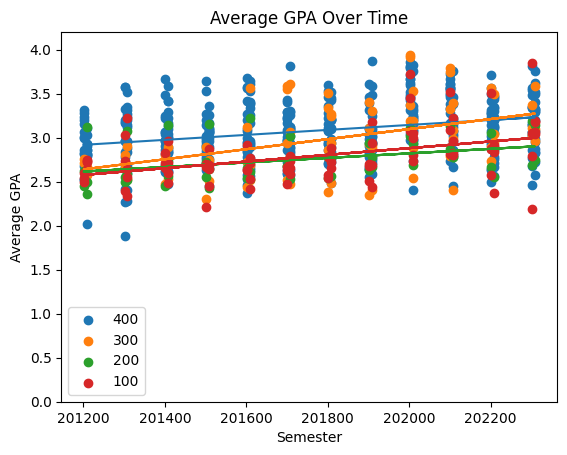

In [299]:
for level in [400,300,200,100]:
    course_data = df.loc[df["level"] == level]

    x = course_data["semester"]
    y = course_data["avg_gpa"]

    plt.scatter(x, y, label=level)

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b)

plt.title("Average GPA Over Time")
plt.xlabel('Semester')
plt.ylabel('Average GPA')
plt.legend()
plt.ylim(0, 4.2)

plt.show()

/var/folders/w8/2krv1jk52m5_qlhl8fs84ryw0000gn/T/ipykernel_15526/500680641.py:13: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x, y, 1)


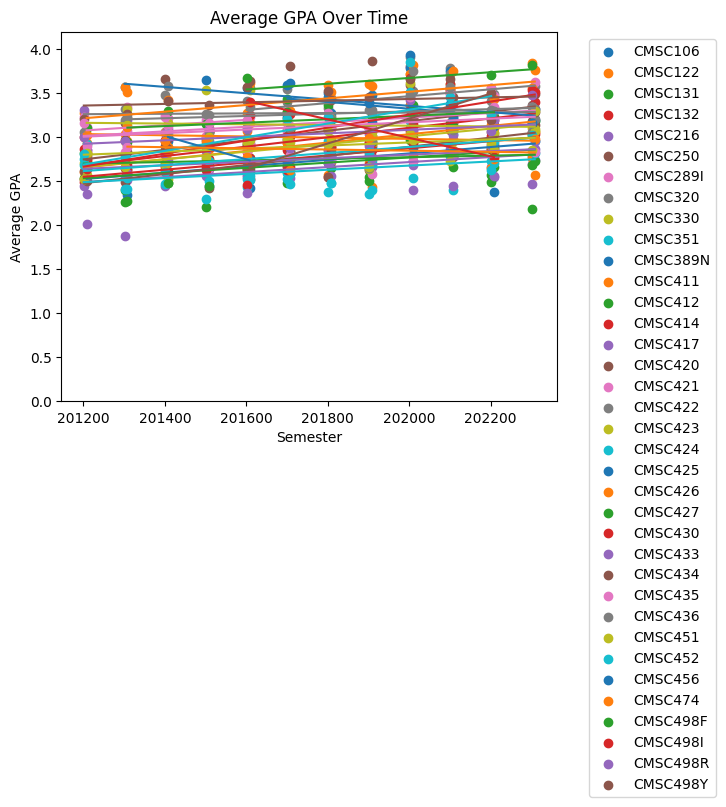

In [300]:
combined_courses = filter(lambda x : x[-1] != 'H', courses)

for course in combined_courses:
    course_data = df[df["course"] == course]

    x = course_data["semester"]
    y = course_data["avg_gpa"]

    plt.scatter(x, y, label=course)

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b)

plt.title("Average GPA Over Time")
plt.xlabel('Semester')
plt.ylabel('Average GPA')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylim(0, 4.2)

plt.show()

One thing to note while looking at these graphs is that the grade data for the 2020 school year is significantly higher than the year before and the year after. This may be due to the COVID-19 pandemic causing courses to adapt and change in a short period of time.

Analyzing our regression lines in the first graph, we can see that for any 1XX, 2XX, 3XX, 4XX level computer science course, the average gpa increased over time. There could be a number of reasons why this is the case, but we are interested in grade inflation. 

In the second graph, things look a little cluttered, but the same trends show for most classes except a few.

## Hypothesis Testing
#### H0: There is no upwards/downwards trend in the average GPA of CMSC courses over time
#### H1: There is a linear trend in the average GPA of CMSC courses over time.
#### alpha = 0.05
### OLS

In [301]:

model = smf.ols(formula="avg_gpa ~ semester", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_gpa   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     72.19
Date:                Fri, 17 May 2024   Prob (F-statistic):           1.38e-16
Time:                        21:07:40   Log-Likelihood:                -208.98
No. Observations:                 640   AIC:                             422.0
Df Residuals:                     638   BIC:                             430.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -64.2900      7.920     -8.117      0.0

Low p-value of 1.33e-16 is less than alpha of 0.05. There is statistically significant evidence the reject the null hypothesis. Since the coefficient is 0.0003, there is a positive correlation between average GPA and time, meaning that there is a 'grade inflation' in the UMD CMSC courses.

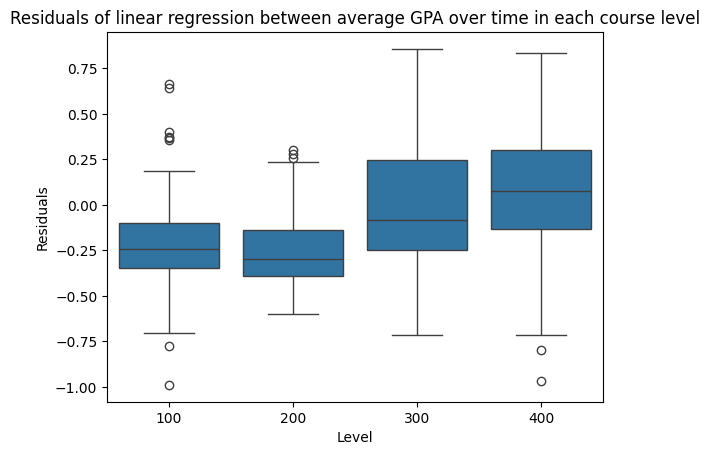

In [302]:


df["residuals"] = model.resid
sns.boxplot(data=df, x="level", y="residuals")
plt.xlabel("Level")
plt.ylabel("Residuals")
plt.title("Residuals of linear regression between average GPA over time in each course level")
plt.show()

Distribution of the model residuals vary slightly across level thus the model residuals are likely not independent of the level. This suggests that regression analysis of average GPA across time should be performed seperately for each level.

In [303]:

model = smf.ols(formula="avg_gpa ~ semester * C(level)", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_gpa   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     26.26
Date:                Fri, 17 May 2024   Prob (F-statistic):           1.24e-31
Time:                        21:07:40   Log-Likelihood:                -161.60
No. Observations:                 640   AIC:                             339.2
Df Residuals:                     632   BIC:                             374.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [304]:

model = smf.ols(formula="avg_gpa ~ semester * C(course)", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_gpa   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     12.57
Date:                Fri, 17 May 2024   Prob (F-statistic):           1.10e-77
Time:                        21:07:40   Log-Likelihood:                 55.774
No. Observations:                 640   AIC:                             30.45
Df Residuals:                     569   BIC:                             347.2
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   